# Creating Corpus

In [1]:
import os
import zipfile
import multiprocessing

from gensim.models import word2vec
from keras.utils.data_utils import get_file

Using TensorFlow backend.


# Downloading the dataset
You can download training data and evaluation data.

In [2]:
def maybe_download(url):
    """
    Download a file if not present.
    """
    filename = url.split('/')[-1]
    path = get_file(filename, url)
    return path
    

def unzip(zip_filename):
    """
    Extract a file from the zipfile
    """
    with zipfile.ZipFile(zip_filename) as f:
        for filename in f.namelist():
            dirname = os.path.dirname(filename)
            f.extract(filename, dirname)
            return os.path.abspath(filename)
            

url = 'http://mattmahoney.net/dc/text8.zip'
filename = maybe_download(url)
text_file = unzip(filename)

# Training the Model
You can read training data from a text file using the word2vec.Text8Corpus class.
By default, it assumes that the text file is given.
Now, we obtained skip-gram model. Let's train it by calling train_on_batch and passing training examples:

In [36]:
sentences = word2vec.Text8Corpus(text_file)
window_sizes = [1, 2, 4, 8, 16]
model_names = {}
for window_size in window_sizes:
    out_model = "text8.ws{}.txt".format(window_size)
    model_names[window_size] = out_model
    if os.path.exists(out_model):
        continue
    print('Starting training with window size {}...'.format(window_size))
    model = word2vec.Word2Vec(sentences, size=200, sg=1, window=window_size, workers=multiprocessing.cpu_count())
    model.wv.save_word2vec_format(out_model)
    # model.save(out_model)
    print('Finished')
print(model_names)

{8: 'text8.ws8.txt', 1: 'text8.ws1.txt', 2: 'text8.ws2.txt', 4: 'text8.ws4.txt', 16: 'text8.ws16.txt'}


## Preparing the text data
First, we will simply iterate over the folders in which our text samples are stored, and format them into a list of samples. We will also prepare at the same time a list of class indices matching the samples:

Then we can format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [27]:
from keras.preprocessing import sequence
from keras.datasets import imdb

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Loading word index...')
word_index = imdb.get_word_index()
print(len(word_index), 'vocabularies')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Loading data...


25000 train sequences
25000 test sequences
Loading word index...
88584

 vocabularies
Pad sequences (samples x time)


X_train shape: (25000, 80)
X_test shape: (25000, 80)


# Preparing the Embedding layer
Next, we compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:

In [14]:
import numpy as np


def prepare_embeddings_index(file_path):
    """
    :param file_path: word vector's file path 
    :return embeddings_index: pre-trained word vectors
    embeddings_index = {'word1': [real numbers],
                        'word2': [real numbers],
                        ...,
                        'wordn': [real numbers]}
    """
    embeddings_index = {}
    embedding_dim = None
    with open(file_path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            embedding_dim = len(coefs)
    
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index, embedding_dim

In [31]:
def create_embedding_matrix(embeddings_index, word_index, embedding_dim):
    #embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    embedding_matrix = np.zeros((max_features + 1, embedding_dim))
    for word, i in word_index.items():
        if i > max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Building the Classifier

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM


def build_model(embedding_matrix, embedding_dim):
    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features + 1, output_dim=embedding_dim, weights=[embedding_matrix]))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # try using a GRU instead, for fun
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Training the model

In [43]:
models = {}
for window_size in sorted(model_names.keys()):
    model_name = model_names[window_size]
    embeddings_index, embedding_dim = prepare_embeddings_index(model_name)
    embedding_matrix = create_embedding_matrix(embeddings_index, word_index, embedding_dim)
    model = build_model(embedding_matrix, embedding_dim)
    print('Train...')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_data=(X_test, y_test), verbose=2)
    file_name = 'model.ws{}.h5'.format(window_size)
    models[window_size] = file_name
    model.save(file_name)

Found 71291 word vectors.
Build model...


Train...


Train on 25000 samples, validate on 25000 samples
Epoch 1/1


296s - loss: 0.6621 - acc: 0.5923 - val_loss: 0.6342 - val_acc: 0.6446


Found 71291 word vectors.
Build model...


Train...


Train on 25000 samples, validate on 25000 samples
Epoch 1/1


KeyboardInterrupt: 

# Evaluation
## Evaluation of Classifier

In [39]:
from keras.models import load_model

accuracies = []
for window_size in window_sizes:
    file_name = models[window_size]
    model = load_model(file_name)
    score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
    accuracies.append(acc)
    print('Test score:', score)
    print('Test accuracy:', acc)

Test score: 0.434176547871
Test accuracy: 0.80996


Test score: 0.411196682043
Test accuracy: 0.8134


Test score: 0.381663848391
Test accuracy: 0.83232


Test score: 0.391271765118
Test accuracy: 0.8266


Test score: 0.382339836626
Test accuracy: 0.8338


## Evaluation of Word Embeddings

In [30]:
import gensim.test
from gensim.models import KeyedVectors
module_path = gensim.test.__path__[0]
spearmans = []
for window_size in window_sizes:
    model_name = model_names[window_size]
    word_vectors = KeyedVectors.load_word2vec_format(model_name)
    _, spearman, _ = word_vectors.evaluate_word_pairs(os.path.join(module_path, 'test_data', 'wordsim353.tsv'))
    spearmans.append(spearman.correlation)
    print(spearman.correlation)

0.546604463077


0.62974217854


0.673909870363


0.711368463157


0.716476219727


## Plotting the evaluation result

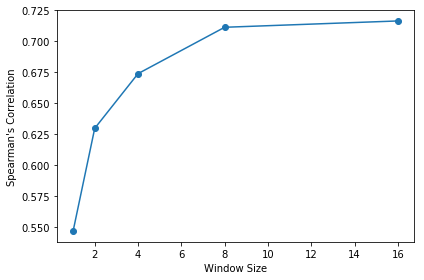

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(window_sizes, spearmans, marker='o')
plt.xlabel('Window Size')
plt.ylabel('Spearman\'s Correlation')

plt.tight_layout()
plt.show()

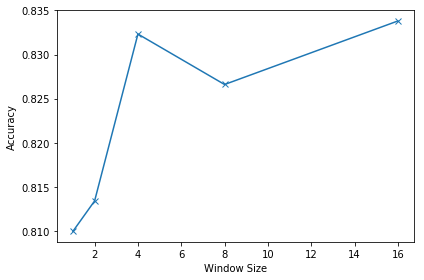

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(window_sizes, accuracies, marker='x')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Result